In [1]:
!pip install rdkit mordred

In [66]:
import pandas as pd
import numpy as np
from rdkit import Chem
from mordred import Calculator, descriptors
import warnings
warnings.filterwarnings('ignore') # To suppress runtime and deprication warnings. 


# Feature Calculation

from https://github.com/rohitfarmer/bittersweet/blob/master/notebooks/feature-calculation-mordred.ipynb

In [67]:
sweet_train = pd.read_csv('data/sweet-train.tsv', sep='\t')
sweet_test = pd.read_csv('data/sweet-test.tsv', sep='\t')
bitter_train = pd.read_csv('data/bitter-train.tsv', sep='\t')
bitter_test = pd.read_csv('data/bitter-test.tsv', sep='\t')

df_sweet = pd.DataFrame()
df_bitter = pd.DataFrame()

# Concatenate train and test set
df_sweet = pd.concat([sweet_train[['Name','SMILES','Sweet']], sweet_test[['Name','SMILES','Sweet']] ])
df_bitter = pd.concat([bitter_train[['Name','SMILES','Bitter']], bitter_test[['Name','SMILES','Bitter']] ])


# Rename taste column as Target.
df_sweet.rename(columns={'Sweet':'Target'}, inplace=True)
df_bitter.rename(columns={'Bitter':'Target'}, inplace=True)

In [68]:
print(df_sweet.count())
df_sweet[df_sweet['SMILES'].isna()] # check if any of the SMILES is a NaN.

Name      2266
SMILES    2366
Target    2366
dtype: int64


,Name,SMILES,Target


In [70]:
print(df_bitter.count())
df_bitter[df_bitter['SMILES'].isna()] # check if any of the SMILES is a NaN.

Name      2291
SMILES    2428
Target    2428
dtype: int64


,Name,SMILES,Target


In [196]:
df_sweet['Target'] = df_sweet['Target'].astype(int) # Convert to numeric

In [197]:
df_bitter['Target'] = df_bitter['Target'].astype(int) # Convert to numeric

In [200]:
# Convert SMILES into Canonical SMILES using RDKit.
def convert_to_canonical_smiles(df):
#     length = df.shape[0]
#     exceptions = 0
#     valid = []
#     for i in range(length):
#         try:
#             c = Chem.CanonSmiles(str(df.iloc[i]['SMILES']))
#             row = df.iloc[i]
#             valid.append({'name': str(row['Name']), 'smiles': str(row['SMILES']), 'Canonical SMILES': c, 'target': 1 if row['Target'] == True else 0})
#         except:
#             exceptions += 1
#             continue
            
#     return valid     
    length = df.shape[0]

    name = []
    smiles = []
    canon_smiles = []
    target = []
    exceptions = 0
    failed_smiles = []
    failed_name = []
    failed_target = []
    for i in range(length):
        try:
            c = Chem.CanonSmiles(str(df.iloc[i]['SMILES']))
            canon_smiles.append(c)
            smiles.append(str(df.iloc[i]['SMILES']))
            target.append(str(df.iloc[i]['Target']))
            name.append(str(df.iloc[i]['Name']))
        except:
            exceptions += 1
            failed_smiles.append(str(df.iloc[i]['SMILES']))
            failed_name.append(str(df.iloc[i]['Target']))
            failed_target.append(str(df.iloc[i]['Name']))
            continue
            
    return {'Name':name, 'SMILES':smiles, 'Canonical SMILES':canon_smiles, 'Target':target}

In [216]:
valid_sweet = convert_to_canonical_smiles(df_sweet)
valid_bitter = convert_to_canonical_smiles(df_bitter)
df_sweet_valid = pd.DataFrame(valid_sweet)
df_bitter_valid = pd.DataFrame(valid_bitter)

[17:14:57] Explicit valence for atom # 2 N, 4, is greater than permitted
[17:14:57] Explicit valence for atom # 2 N, 4, is greater than permitted
[17:14:57] Explicit valence for atom # 5 N, 4, is greater than permitted
[17:14:57] Explicit valence for atom # 6 N, 4, is greater than permitted
[17:14:57] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:14:57] Explicit valence for atom # 9 N, 4, is greater than permitted
[17:14:57] Explicit valence for atom # 11 N, 4, is greater than permitted
[17:14:57] Explicit valence for atom # 3 N, 4, is greater than permitted
[17:14:57] Explicit valence for atom # 3 N, 4, is greater than permitted
[17:14:57] Explicit valence for atom # 3 N, 4, is greater than permitted
[17:14:57] Explicit valence for atom # 2 N, 4, is greater than permitted
[17:14:57] SMILES Parse Error: unclosed ring for input: '[NaH].[NaH].O1[C@@H](OC2CC[C@]3([C@H]4[C@@](CC[C@H]3C2(C)C)(C)[C@@]2(CC[C@@]3([C@@H](C2=CC4=O)C[C@@](CC3)(C(O)=O)C)C)C)C)C(O[C@@H]2OC(C(O)=

In [217]:
df_sweet_valid.describe()

,Name,SMILES,Canonical SMILES,Target
count,2342,2342,2342,2342
unique,2185,2342,2338,2
top,nan,OCC1OC(C(C1O)O)(CO)OC1OC(CO)C(C(C1O)O)O,O=C1NS(=O)(=O)c2cc([N+](=O)[O-])ccc21,1
freq,100,1,2,1240


In [218]:
df_bitter_valid.describe()

,Name,SMILES,Canonical SMILES,Target
count,2404,2404,2404,2404
unique,2202,2397,2393,2
top,nan,c1coc(c12)c(OC)c3c(c2)ccc(=O)o3,O=C1NS(=O)(=O)c2c1cccc2[N+](=O)[O-],0
freq,137,2,2,1502


In [219]:
df_sweet_valid[df_sweet_valid['Canonical SMILES'].isna()]

,Name,SMILES,Canonical SMILES,Target


In [220]:
df_bitter_valid[df_bitter_valid['Canonical SMILES'].isna()]

,Name,SMILES,Canonical SMILES,Target


In [221]:
# Remove duplicates
df_sweet_valid.drop_duplicates(subset="Canonical SMILES", inplace=True)
df_bitter_valid.drop_duplicates(subset="Canonical SMILES", inplace=True)

# Reset index
df_sweet_valid.reset_index(drop=True, inplace = True)
df_bitter_valid.reset_index(drop=True, inplace = True)

In [222]:
# Calculate Descriptors
calc = Calculator(descriptors, ignore_3D=False)
mols_sweet = [Chem.MolFromSmiles(smi) for smi in list(df_sweet_valid['Canonical SMILES'])]
mols_bitter = [Chem.MolFromSmiles(smi) for smi in list(df_bitter_valid['Canonical SMILES'])]

[17:14:59] WARNING: not removing hydrogen atom without neighbors
[17:14:59] WARNING: not removing hydrogen atom without neighbors
[17:14:59] WARNING: not removing hydrogen atom without neighbors
[17:14:59] WARNING: not removing hydrogen atom without neighbors
[17:14:59] WARNING: not removing hydrogen atom without neighbors
[17:14:59] WARNING: not removing hydrogen atom without neighbors
[17:14:59] WARNING: not removing hydrogen atom without neighbors
[17:14:59] WARNING: not removing hydrogen atom without neighbors


In [223]:
df_sweet_descriptors = calc.pandas(mols_sweet, quiet = True, ipynb = True)
df_bitter_descriptors = calc.pandas(mols_bitter, quiet = True, ipynb = True)

/Users/kristianespina/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/kristianespina/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[17:15:39] WARNING: not removing hydrogen atom without neighbors
[17:15:39] WARNING: not removing hydrogen atom without neighbors
[17:15:39] WARNING: not removing hydrogen atom without neighbors
[17:15:40] WARNING: not removing hydrogen atom without neighbors
[17:15:40] WARNING: not removing hydrogen atom without neighbors
[17:15:40] WARNING: not removing hydrogen atom without neighbors
[17:15:40] WARNING: not removing hydrogen atom without neighbors
[17:15:40] WARNING: not removing hydrogen atom without neighbors
[17:15:40] WARNING: not removing hydrogen atom without neighbors


/Users/kristianespina/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/kristianespina/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/kristianespina/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/kristianespina/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/kristianespina/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[17:17:17] WARNING: not removing hydrogen atom without neighbors
[17:17:17] WARNING: not removing hydrogen atom without neighbors
[17:17:17] WARNING: not removing hydrogen atom without neighbors


/Users/kristianespina/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[17:18:26] WARNING: not removing hydrogen atom without neighbors
[17:18:26] WARNING: not removing hydrogen atom without neighbors
[17:18:26] WARNING: not removing hydrogen atom without neighbors
[17:18:27] WARNING: not removing hydrogen atom without neighbors
[17:18:27] WARNING: not removing hydrogen atom without neighbors
[17:18:27] WARNING: not removing hydrogen atom without neighbors
[17:18:28] WARNING: not removing hydrogen atom without neighbors
[17:18:28] WARNING: not removing hydrogen atom without neighbors
[17:18:28] WARNING: not removing hydrogen atom without neighbors


/Users/kristianespina/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/kristianespina/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/kristianespina/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/kristianespina/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/kristianespina/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[17:19:53] WARNING: not removing hydrogen atom without neighbors
[17:19:53] WARNING: not removing hydrogen atom without neighbors
[17:19:53] WARNING: not removing hydrogen atom without neighbors


In [224]:
df_sweet_base = df_sweet_valid[['Name', 'SMILES', 'Canonical SMILES']]
df_sweet_with_descriptors = pd.concat([df_sweet_base, df_sweet_descriptors, df_sweet_valid[['Target']]], axis=1)
df_bitter_base = df_bitter_valid[['Name', 'SMILES', 'Canonical SMILES']]
df_bitter_with_descriptors = pd.concat([df_bitter_base, df_bitter_descriptors, df_bitter_valid[['Target']]], axis=1)

In [225]:
df_sweet_with_descriptors.to_csv('mordred/sweet_descriptor.csv', index=False)
df_bitter_with_descriptors.to_csv('mordred/bitter_descriptor.csv', index=False)

# Load Data

In [20]:
# Python 2 script.
from __future__ import division

# External library.
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.preprocessing import MinMaxScaler




In [21]:
def nan_filter(data, thresh=80, value='zero'):
    """
    Purpose
    -------
    1. Drop columns with all the values as NaNs.
    2. Drop columns with NaNs over a certian limit.
    3. Replace NaNs with a value.
    
    Arguments
    ---------
    data: Dataframe.
    thresh: Threshold for non-NaN values; default is 80%.
    value: Value to replace NaN with; default is zero.
           Options: 'zero', 'mean', 'median'
    
    Returns
    -------
    A modified Pandas dataframe.
    """
    
    data = data.dropna(axis='columns', how='all')
    threshold = int((data.shape[0] * thresh) / 100)
    data = data.dropna(axis='columns', thresh=thresh)
    if value == 'zero':
        data = data.apply(lambda x: x.fillna(0)) 
    elif value == 'mean':
        data = data.apply(lambda x: x.fillna(x.mean()))
    elif value == 'median':
        data = data.apply(lambda x: x.fillna(x.median()))
  
    return data




In [22]:
def variance_thresh(data, thresh=0.0):
    """
    Purpose
    -------
    1. Select columns with variace greater than a specified threshold.
    
    Arguments
    ---------
    data: Dataframe with column values in float64 and devoid of missing values.
    thresh: Variace threshold. Default is 0.0 (float)
    
    Returns
    -------
    A modified Pandas dataframe.
    """
    
    selector = VarianceThreshold(threshold=thresh)
    selector.fit(data)
    idx = np.where(selector.variances_ > thresh)[0]
    cols = data.columns[idx]
    df = data[cols]
    
    return df

In [23]:
def normalize_mm(data, feat_range=(0,1)):
    """
    Purpose
    -------
    Transforms features by scaling each feature to a given range using  Scikit-learn MinMaxScaler.
    
    Arguments
    ---------
    data: Pandas dataframe.
    feat_range: Scale range in a tuple. Default is (0,1)
    
    Returns
    -------
    Transformed Pandas dataframe.
    
    """
    cols = list(data.columns)
    ind = list(data.index)
    scaler = MinMaxScaler(feature_range=feat_range)
    scaler.fit(data)
    df = pd.DataFrame(data=scaler.transform(data), index=ind, columns=cols)
    
    return df



In [24]:
def select_k_chi2(X, y, k=1):
    """
    Purpose
    -------
    Select K best features using Chi squared test.
    
    Arguments
    ---------
    X: Features in a Pandas dataframe.
    y: Targets in a Pandas dataframe.
    k: Value for k-best feature estimation.
    
    Returns
    -------
    A Pandas dataframe with the k-best features.
    """
    
    selector = SelectKBest(chi2, k=k).fit(X, y)
    mask = selector.get_support()
    new_features = X.columns[mask]
    
    return X[new_features]

Load Data

In [25]:
# Load the original dataset with all the features calculated in feature-calculation-mordred notebook.
df = pd.read_csv('output/bitter_sweet_2d_plus_3d_descriptors.tsv.gz', compression='gzip', sep="\t", index_col=0, dtype='str')



In [26]:
df

,Name,SMILES,Canonical SMILES,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,Target
0,Sucrose,OCC1OC(C(C1O)O)(CO)OC1OC(CO)C(C(C1O)O)O,OCC1OC(OC2(CO)OC(CO)C(O)C2O)C(O)C(O)C1O,17.213261503245107,16.059815204624506,0,0,28.7667348566669,2.5224203882661214,4.958230025475284,...,72.3178208023914,342.11621152400056,7.602582478311124,1110,43,120.0,147.0,10.451388888888888,5.291666666666664,Sweet
1,"Sucralose / 4,1',6'-Trichloro-galactosucrose",ClCC1OC(C(C1O)O)(CCl)OC1OC(CO)C(C(C1O)O)Cl,OCC1OC(OC2(CCl)OC(CCl)C(O)C2O)C(O)C(O)C1Cl,17.213261503245107,16.059815204624506,0,0,28.7667348566669,2.5224203882661214,4.958230025475284,...,72.3178208023914,396.0145506080005,9.42891787161906,1110,43,120.0,147.0,10.451388888888888,5.291666666666664,Sweet
2,Aspartame/Aspartyl-phenylalanine methylester,COC(=O)C(NC(=O)C(CC(=O)O)N)Cc1ccccc1,COC(=O)C(Cc1ccccc1)NC(=O)C(N)CC(=O)O,15.315311174583632,13.970681088761472,1,1,25.367666563930996,2.2875334901511377,4.5750669803022745,...,53.670480147148865,294.1215716760005,7.541578760923089,1000,27,96.0,105.0,8.916666666666666,4.888888888888889,Sweet
3,Tagatose,OCC1(O)OCC(C(C1O)O)O,OCC1(O)OCC(O)C(O)C1O,8.82987961020159,8.71559123720356,0,0,14.640474984817839,2.4182893140510573,4.836578628102114,...,43.370989242179924,180.063388104,7.5026411710000005,178,20,60.0,71.0,6.145833333333333,2.7222222222222228,Sweet
4,Isomaltulose/Palatinose,OCC1OC(OCC2OC(C(C2O)O)(O)CO)C(C(C1O)O)O,OCC1OC(OCC2OC(O)(CO)C(O)C2O)C(O)C(O)C1O,17.372180125842995,15.638061370199232,0,0,28.65007669208163,2.4784040495346007,4.876166945512816,...,72.20412904244861,342.11621152400056,7.602582478311124,1220,41,120.0,145.0,10.451388888888888,5.166666666666665,Sweet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2333,Isovanillic 24,O1c2cc(O)c(O)cc2C2c3c(OC[C@@]12O)c(O)c(O)cc3,Oc1cc2c(cc1O)C1c3ccc(O)c(O)c3OC[C@@]1(O)O2,17.929456992768486,14.412750313580602,0,0,28.33692603461081,2.6128329480551606,5.116646258260108,...,72.02179076900988,304.0583027240003,8.942891256588245,912,44,130.0,163.0,7.8125,4.527777777777777,Sweet
2334,Naringin DHC,O1C(CO)C(O)C(O)C(OC2OC(C)C(O)C(O)C2O)C1Oc1cc(O...,CC1OC(OC2C(Oc3cc(O)c(C(=O)CCc4ccc(O)cc4)c(O)c3...,31.76175510990119,24.298458975082983,0,0,51.640551016072976,2.4682759468781197,4.93655189375624,...,78.4593390300359,582.1948557680008,7.762598076906678,6188,73,216.0,257.0,16.13888888888889,8.972222222222218,Sweet
2335,Polypodoside A,O1[C@H](OC2CC[C@]3([C@H](C2)C(=O)C=C2[C@H]4CC[...,CC1CC[C@H](C(C)[C@H]2CC[C@@H]3C4=CC(=O)[C@H]5C...,49.55591225507042,34.56215687064316,0,0,79.85826001512984,2.6367337389312957,5.234851429657418,...,116.63981199885743,884.476950844002,6.600574260029865,19191,130,354.0,441.0,23.51388888888889,13.083333333333327,Sweet
2336,Potassium saccharin,[KH].S1(=O)(=O)NC(=O)c2c1cccc2,O=C1NS(=O)(=O)c2ccccc21.[KH],9.477125414503671,8.806332736972081,0,0,multiple fragments (SpAbs_A/SpAbs),multiple fragments (SpMax_A/SpMax),multiple fragments (SpDiam_A/SpDiam),...,59.31084525600276,222.970545732,11.735291880631578,1200000170,18,66.0,79.0,divide by zero encountered in power (mZagreb1),2.513888888888889,Sweet


In [27]:
columns = df.columns

In [28]:
# Separate data into feature and target dataframes.
X = df[columns[3:-1]]
X = X.apply(pd.to_numeric, errors='coerce') # Change numbers as strings to numeric 
                                            # and relpace strings with NaNs.
#X = X.astype(dtype='float64') # Convert dtypes to float64.


In [29]:
X['nAcid'].dtype


dtype('int64')

In [30]:

X['SMR_VSA2'] = X['SMR_VSA2'].astype(dtype='int64')

In [31]:
y = df.loc[:,columns[-1:]]

In [32]:
y = df.loc[:,columns[-1:]]
y.Target.replace(to_replace='Sweet', value=1, inplace=True) # Replace 'Sweet' label with 1.
y.Target.replace(to_replace='Bitter', value=0, inplace=True) # Replace 'Bitter' label with 0.


In [33]:
# Print some metrics about the data.
print ("Total number of features: " + str(X.shape[1]))
print ("Total number of samples: "+ str(X.shape[0]))
print ("To check if there are any null values in the features and how many: ", \
       X.isnull().values.any(), X.isnull().sum().sum())
print ("To check if there are any null values in the target and how many:", \
       y.isnull().values.any(), y.isnull().sum().sum()) 
print ("The total number of Sweet targets: " + str(y[y.Target == 1].count()[0]))
print ("The total number of Bitter targets: " + str(y[y.Target == 0].count()[0]))


Total number of features: 1826
Total number of samples: 2338
To check if there are any null values in the features and how many:  True 995554
To check if there are any null values in the target and how many: False 0
The total number of Sweet targets: 1239
The total number of Bitter targets: 0


In [34]:

# Replace NaNs with the column mean. Keep columns with atleast 80% non NaNs. 
# Remove columns with only NaN values.
X_no_nan = nan_filter(data=X, thresh=80, value='mean')



In [35]:

print ("To check if there are any null values in the features after fixing nans and how many: ", X_no_nan.isnull().values.any(), X_no_nan.isnull().sum().sum() )
print ("Total number of features left after fixing NaNs: ", X_no_nan.shape[1]) 

To check if there are any null values in the features after fixing nans and how many:  False 0
Total number of features left after fixing NaNs:  1477


In [36]:
X_no_nan.head(1)



,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,17.213262,16.059815,0,0,28.766735,2.52242,4.95823,28.766735,1.250728,4.052767,...,10.247042,72.317821,342.116212,7.602582,1110,43,120.0,147.0,10.451389,5.291667


In [37]:
X_no_nan_norm = normalize_mm(X_no_nan)

In [38]:

X_ =  pd.concat([X_no_nan_norm,y], axis=1)
X_.to_pickle('output/X_all.pkl', compression='gzip')


Split train test 

In [60]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score



In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_no_nan_norm, y, test_size=0.33, random_state=42)

In [50]:
X_train.iloc[0,0].dtype

dtype('float64')

In [55]:
y_train=y_train.replace('Non_Sweet',0)
y_train= y_train.astype('int')

In [56]:
y_test=y_test.replace('Non_Sweet',0)
y_test= y_test.astype('int')

# XGBClassifier

In [57]:
model = XGBClassifier()

In [58]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [61]:
y_pred = model.predict(X_test)

print("Accuracy of Model::",accuracy_score(y_test,y_pred))
print("Precision of Model::",precision_score(y_test,y_pred))

Accuracy of Model:: 0.8601036269430051
Precision of Model:: 0.859122401847575


In [46]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 2.9 MB/s eta 0:00:0000:0100:01


# CatBoost

In [45]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 4.2 MB/s eta 0:00:00


In [62]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    iterations=100, 
    learning_rate=0.2, 
    #loss_function='CrossEntropy'
)

clf.fit(X_train, y_train)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())



0:	learn: 0.5853672	total: 129ms	remaining: 12.8s
1:	learn: 0.5199621	total: 168ms	remaining: 8.24s
2:	learn: 0.4743307	total: 209ms	remaining: 6.77s
3:	learn: 0.4361234	total: 252ms	remaining: 6.06s
4:	learn: 0.4090514	total: 296ms	remaining: 5.63s
5:	learn: 0.3807889	total: 343ms	remaining: 5.38s
6:	learn: 0.3638205	total: 399ms	remaining: 5.3s
7:	learn: 0.3446217	total: 441ms	remaining: 5.07s
8:	learn: 0.3300920	total: 482ms	remaining: 4.87s
9:	learn: 0.3170042	total: 523ms	remaining: 4.71s
10:	learn: 0.3076142	total: 568ms	remaining: 4.59s
11:	learn: 0.3006758	total: 612ms	remaining: 4.49s
12:	learn: 0.2915792	total: 653ms	remaining: 4.37s
13:	learn: 0.2848231	total: 694ms	remaining: 4.26s
14:	learn: 0.2800151	total: 735ms	remaining: 4.17s
15:	learn: 0.2730961	total: 777ms	remaining: 4.08s
16:	learn: 0.2664502	total: 819ms	remaining: 4s
17:	learn: 0.2615833	total: 859ms	remaining: 3.91s
18:	learn: 0.2536868	total: 905ms	remaining: 3.86s
19:	learn: 0.2509545	total: 946ms	remaining: 

In [65]:
y_pred = clf.predict(X_test)

print("Accuracy of Model::",accuracy_score(y_test,y_pred))
print("Precision of Model::",precision_score(y_test,y_pred))

Accuracy of Model:: 0.8652849740932642
Precision of Model:: 0.8654292343387471


# Boruta Shap

In [121]:
!pip install BorutaShap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 28.4 MB/s 


In [126]:
y_train = pd.DataFrame(y_train)
y_train['Target']

1161    1
2196    0
1911    0
2121    1
1273    1
       ..
1638    0
1095    1
1130    1
1294    1
860     1
Name: Target, Length: 1603, dtype: int64

In [128]:
from BorutaShap import BorutaShap

# If no model is selected default is the Random Forest
# If classification is True it is a classification problem
Feature_Selector = BorutaShap(importance_measure='shap', classification=True)

Feature_Selector.fit(X=X_train, y=y_train['Target'], n_trials=50, random_state=0)

  0%|          | 0/50 [00:00<?, ?it/s]

110 attributes confirmed important: ['MATS4m', 'SMR_VSA5', 'BCUTv-1h', 'ETA_dBeta', 'MATS4Z', 'AATS0p', 'BCUTZ-1l', 'MWC05', 'Xpc-6dv', 'AXp-4d', 'BCUTd-1h', 'GATS4dv', 'AATSC4c', 'AETA_dBeta', 'TpiPC10', 'BCUTv-1l', 'Xp-7dv', 'MWC06', 'AATS4i', 'GATS1v', 'SRW10', 'BCUTpe-1h', 'SpMax_A', 'MWC09', 'piPC2', 'ETA_beta_ns', 'BCUTi-1l', 'BCUTdv-1l', 'FCSP3', 'AMID', 'Xpc-6d', 'GATS2v', 'AXp-5d', 'ATSC2i', 'MATS6v', 'GATS2se', 'piPC9', 'HybRatio', 'piPC7', 'BertzCT', 'BCUTp-1l', 'AATSC0i', 'AATS4p', 'BCUTse-1h', 'AATS2v', 'piPC10', 'piPC4', 'MID_C', 'BCUTp-1h', 'BCUTare-1h', 'ATSC1d', 'BCUTi-1h', 'fMF', 'piPC5', 'AXp-3d', 'MDEO-12', 'GATS2c', 'ATS5p', 'BalabanJ', 'ETA_epsilon_3', 'AETA_beta_ns', 'AATS1v', 'AETA_beta', 'AMID_N', 'BCUTse-1l', 'VSA_EState1', 'NssO', 'PEOE_VSA8', 'ETA_beta', 'BCUTdv-1h', 'AATSC6v', 'AATS7i', 'AATS0v', 'BCUTare-1l', 'AATSC4dv', 'MINdO', 'ATSC4dv', 'AATS2p', 'AATS3v', 'GATS2are', 'MPC6', 'Xp-6d', 'GATS1d', 'AATS3d', 'AETA_eta_L', 'SssO', 'AATSC4m', 'Mp', 'AATS3p',

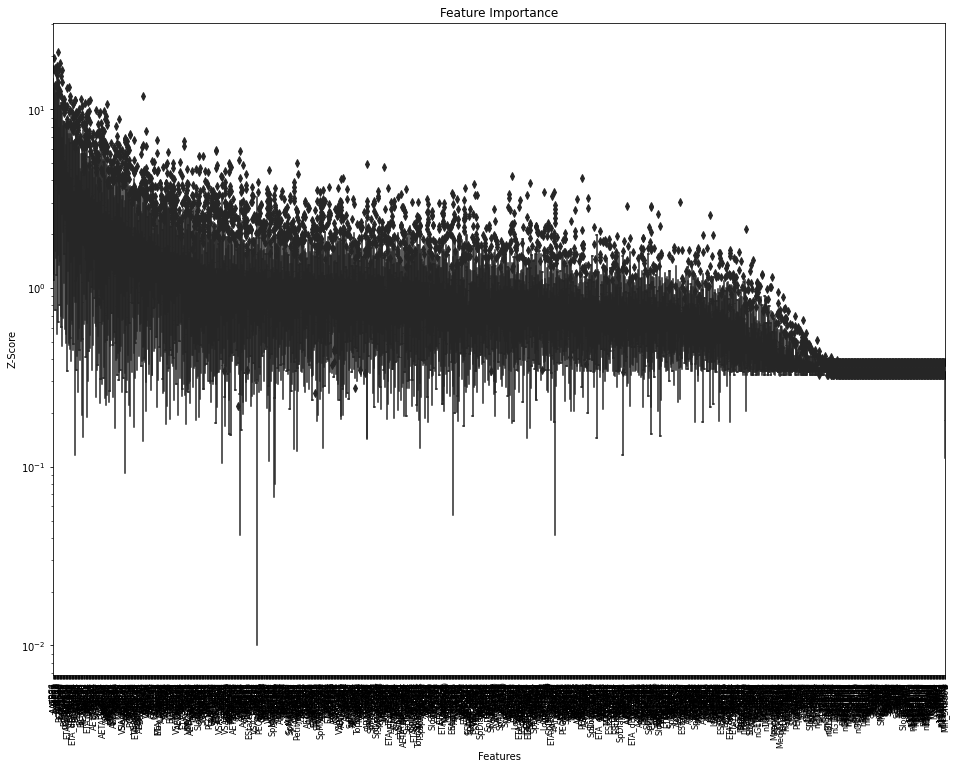

In [129]:
Feature_Selector.plot(which_features='all', figsize=(16,12))

In [130]:
subset = Feature_Selector.Subset()

In [133]:
subset_cols = subset.columns
subset_cols

Index(['MATS4m', 'SMR_VSA5', 'BCUTv-1h', 'ETA_dBeta', 'MATS4Z', 'AATS0p',
       'BCUTZ-1l', 'MWC05', 'Xpc-6dv', 'AXp-4d',
       ...
       'ETA_dEpsilon_B', 'ATSC2d', 'AATS3i', 'MAXssO', 'BCUTc-1l', 'MATS4c',
       'AXp-0d', 'MATS1c', 'piPC3', 'ETA_eta_FL'],
      dtype='object', length=110)

In [134]:
X_test_subset = X_test[subset_cols]

# XGBClassifier

In [135]:
model = XGBClassifier()

In [136]:
model.fit(subset, y_train)

XGBClassifier(objective='multi:softprob')

In [137]:
y_pred = model.predict(X_test_subset)

print("Accuracy of Model::",accuracy_score(y_test,y_pred))

Accuracy of Model:: 0.7645569620253164


# CatBoost

In [140]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    iterations=500, 
    learning_rate=0.15, 
    #loss_function='CrossEntropy'
)

clf.fit(subset, y_train)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())



0:	learn: 0.9978542	total: 123ms	remaining: 1m 1s
1:	learn: 0.9216229	total: 217ms	remaining: 53.9s
2:	learn: 0.8655781	total: 393ms	remaining: 1m 5s
3:	learn: 0.8194731	total: 521ms	remaining: 1m 4s
4:	learn: 0.7804043	total: 683ms	remaining: 1m 7s
5:	learn: 0.7492254	total: 823ms	remaining: 1m 7s
6:	learn: 0.7215562	total: 959ms	remaining: 1m 7s
7:	learn: 0.6992280	total: 1.09s	remaining: 1m 6s
8:	learn: 0.6820362	total: 1.23s	remaining: 1m 6s
9:	learn: 0.6640083	total: 1.35s	remaining: 1m 6s
10:	learn: 0.6465847	total: 1.49s	remaining: 1m 6s
11:	learn: 0.6314404	total: 1.65s	remaining: 1m 7s
12:	learn: 0.6157924	total: 1.77s	remaining: 1m 6s
13:	learn: 0.6029463	total: 1.86s	remaining: 1m 4s
14:	learn: 0.5940458	total: 1.96s	remaining: 1m 3s
15:	learn: 0.5806964	total: 2.09s	remaining: 1m 3s
16:	learn: 0.5721175	total: 2.22s	remaining: 1m 2s
17:	learn: 0.5652276	total: 2.35s	remaining: 1m 2s
18:	learn: 0.5598814	total: 2.47s	remaining: 1m 2s
19:	learn: 0.5495410	total: 2.54s	remaini

In [141]:
y_pred = clf.predict(X_test_subset)

print("Accuracy of Model::",accuracy_score(y_test,y_pred))


Accuracy of Model:: 0.779746835443038
